## Data Cleaning

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

#Load file
rawDataframe = pd.read_csv("data.csv", delimiter=";")

print(f"We got {len(rawDataframe)} rows and {len(rawDataframe.columns)} columns")

#Extract Data
features = pd.DataFrame()

dataframe=rawDataframe.iloc[:,[2,4,6,8,12,14,16,18,21,24,26,28,30,33,37,41,43]]
pd.options.mode.chained_assignment = None

#Treat string data as NaN
for col in dataframe:
    dataframe[col]=pd.to_numeric(dataframe[col], errors='coerce') 

#Replace NaN by median value
imp = SimpleImputer(missing_values=pd.NA, strategy='median')
dataframe=pd.DataFrame(imp.fit_transform(dataframe))

features['GB'] = dataframe.iloc[:,0]
features['GR'] = dataframe.iloc[:,1]
features['Epi'] = dataframe.iloc[:,2]
features['Nepi'] = dataframe.iloc[:,3]
features['Bacterie'] = dataframe.iloc[:,4]
features['CylH'] = dataframe.iloc[:,5]
features['CylP'] =dataframe.iloc[:,6] 
features['Crystaux'] =dataframe.iloc[:,7]
features['ERY'] = dataframe.iloc[:,8]
features['LEU'] = dataframe.iloc[:,9]
features['NIT'] = dataframe.iloc[:,10]
features['KET'] = dataframe.iloc[:,11]
features['GLU'] = dataframe.iloc[:,12]
features['PRO'] = dataframe.iloc[:,13]
features['PH'] = dataframe.iloc[:,14]
features['SG'] = dataframe.iloc[:,15]
features['target'] = dataframe.iloc[:,16]
print(f"We will work with {len(features)} rows and {len(features.columns)} columns")
features

We got 181 rows and 52 columns
We will work with 181 rows and 17 columns


,GB,GR,Epi,Nepi,Bacterie,CylH,CylP,Crystaux,ERY,LEU,NIT,KET,GLU,PRO,PH,SG,target
0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,69.18,69.59,66.65,51.85,70.12,64.38,68.07,1.012,0.0
1,900.00,15.84,2.20,0.00,40.04,0.0,0.00,0.00,10.15,35.06,64.81,54.41,69.66,60.91,67.59,1.022,0.0
2,629.64,429.44,3.08,9.68,41.36,0.0,0.00,0.00,6.50,39.10,37.62,52.29,72.14,57.17,9.31,1.015,1.0
3,0.00,4.40,1.76,0.00,47.96,0.0,0.00,0.00,71.70,62.51,65.33,55.07,72.65,65.90,33.27,1.004,0.0
4,91.74,7.04,7.92,1.76,64.24,0.0,0.00,0.00,44.57,49.38,65.46,48.03,68.66,59.06,68.37,1.022,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,900.00,1800.00,0.00,0.00,2904.00,0.0,14.70,0.00,4.94,26.58,63.28,51.95,67.17,50.65,63.65,1.019,0.0
177,91.38,1663.20,0.00,0.51,434.58,0.0,14.72,21.32,7.47,46.19,63.13,51.97,71.11,54.92,68.01,1.016,0.0
178,495.00,452.60,18.90,0.00,3997.70,0.0,18.90,0.00,7.77,27.30,65.50,54.51,68.75,41.22,37.18,1.018,1.0
179,257.40,1047.20,0.00,0.00,1839.20,0.0,26.40,1025.20,5.05,58.77,64.89,47.05,68.93,58.73,12.04,1.013,0.0


## Raw Visualization

<Axes: >

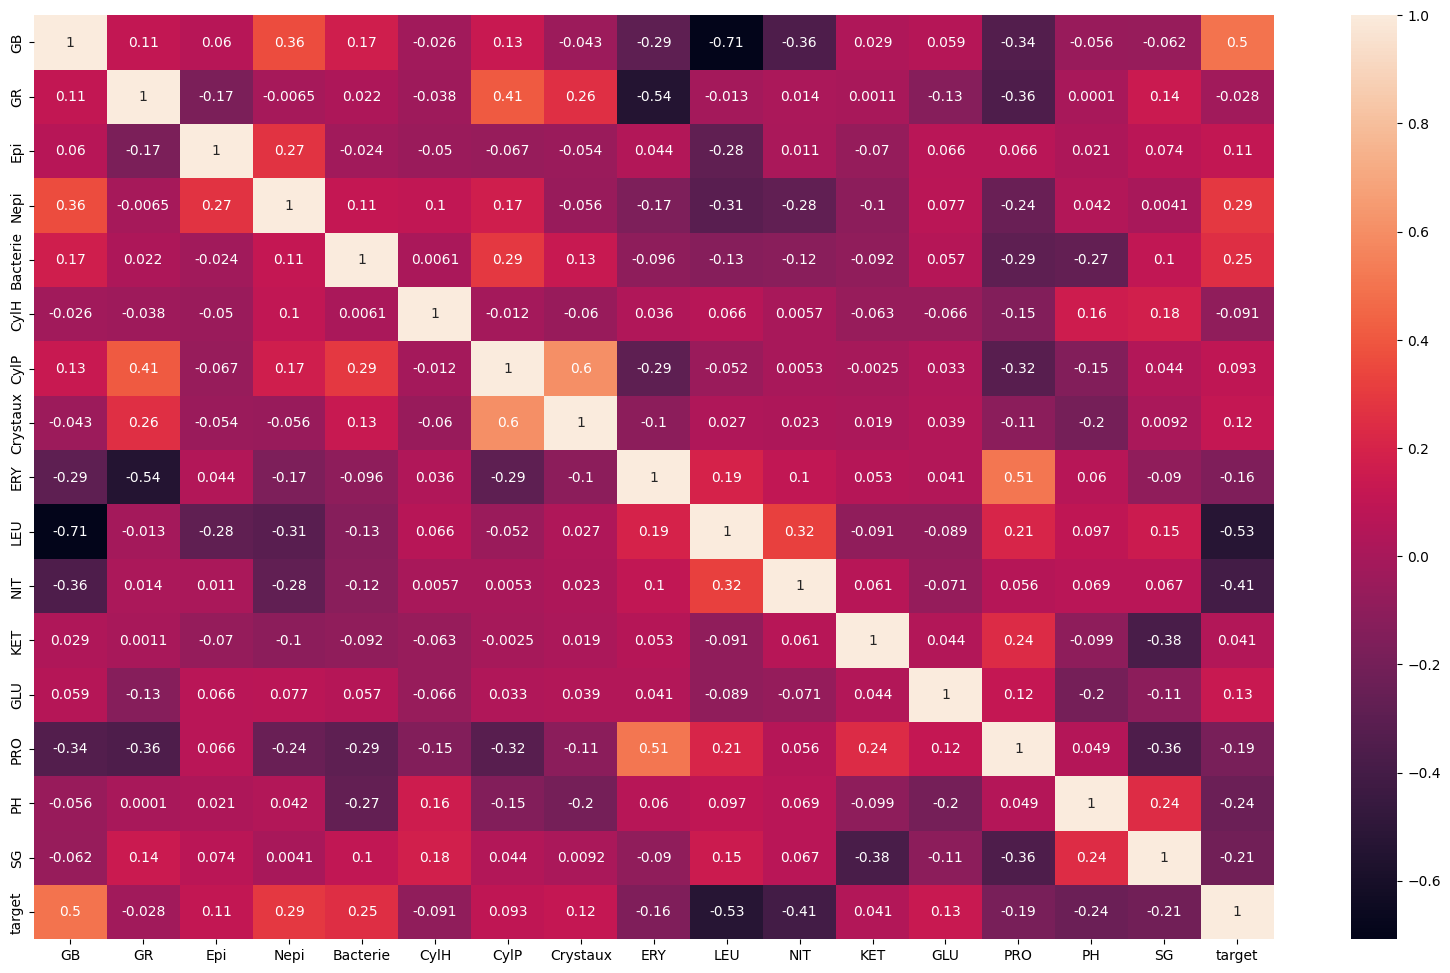

In [79]:
#Let's try to see the matrix of correlation
import seaborn as sns
		     
plt.figure(figsize=(20,12))
sns.heatmap(features.corr(),annot = True)

<Axes: >

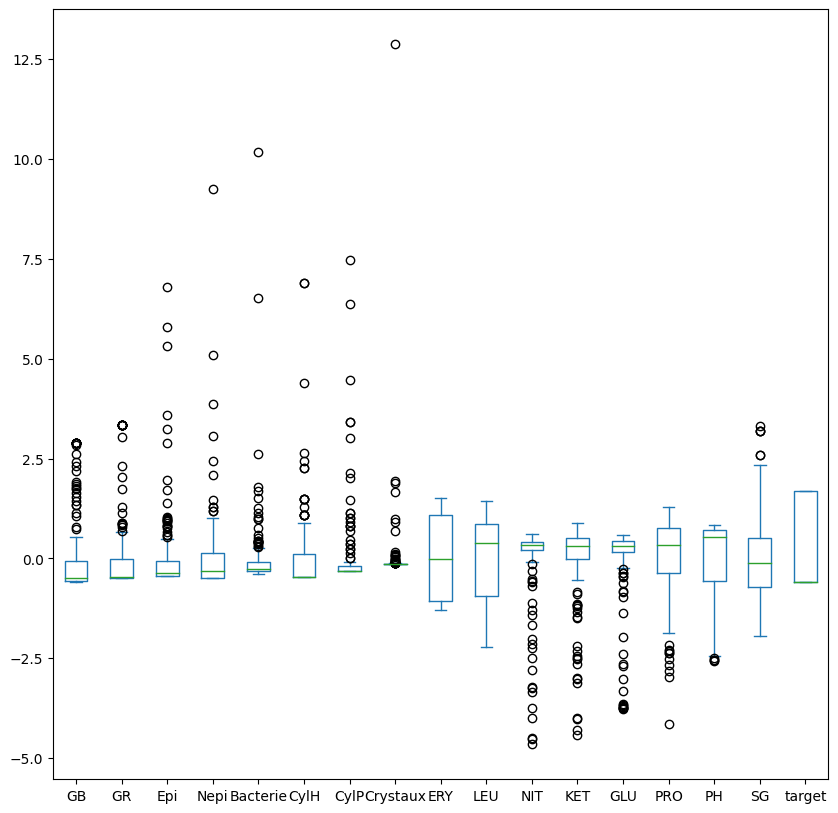

In [80]:
pd.DataFrame(preprocessing.scale(features),columns = features.columns).plot.box(figsize=(10,10))

## Splitting train with test data

In [81]:
from sklearn.model_selection import train_test_split
target = features.iloc[:,16]
features = features.drop('target',axis=1)
X_train, X_test, Y_train,Y_test = train_test_split(features, target, test_size=0.2)
scaledTrain = pd.DataFrame(preprocessing.scale(X_train),columns = features.columns)
scaledTest = pd.DataFrame(preprocessing.scale(X_test),columns = features.columns)
scaledTrain

,GB,GR,Epi,Nepi,Bacterie,CylH,CylP,Crystaux,ERY,LEU,NIT,KET,GLU,PRO,PH,SG
0,-0.595832,-0.481133,-0.427097,-0.587511,-0.073693,-0.471746,-0.304303,0.606565,1.373711,0.728303,0.338426,-4.735017,0.207056,-0.004478,-0.656048,-0.063932
1,-0.527245,-0.479276,-0.262022,-0.475125,-0.102877,-0.471746,-0.304303,0.803285,0.004322,-1.895815,0.578784,0.432646,0.503449,-1.241505,-2.535611,-0.820613
2,-0.590933,-0.481133,-0.406463,-0.475125,-0.299424,-0.471746,-0.179968,-0.133553,1.106793,0.868341,0.353231,0.209012,0.270182,0.843411,0.784289,0.314408
3,0.104732,-0.466272,1.058573,0.199195,-0.231228,-0.471746,-0.304303,-0.131940,1.197743,-1.038879,0.344523,0.340898,0.494431,0.868517,0.596815,-0.568386
4,-0.517447,-0.468130,-0.365194,0.086809,-0.266666,1.226179,-0.304303,-0.133553,1.212374,-0.119085,0.363681,-0.252018,0.421084,0.402920,0.191335,-0.063932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-0.404769,-0.481133,1.471259,0.086809,-0.272325,-0.471746,-0.179968,-0.117428,1.262989,0.612135,0.427254,0.180341,-0.928016,0.537578,0.444693,0.566634
140,-0.529694,-0.469988,0.831596,-0.025578,-0.296446,-0.471746,-0.055633,-0.133553,-1.205706,0.550073,0.264403,0.182634,0.231705,0.168980,-1.044388,0.314408
141,-0.078982,-0.390109,-0.365194,0.648742,-0.197577,0.164976,-0.304303,-0.133553,-0.686106,-0.547951,0.453380,0.540449,0.584612,0.349285,0.547536,-0.442273
142,-0.586033,-0.479276,-0.096948,-0.475125,-0.288108,1.013938,-0.304303,-0.128715,1.104025,0.780021,0.152062,-1.481431,-3.600364,-0.022736,-0.085591,1.575541


## Treating the imbalance

In [82]:
# class set is imbalanced !
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
print(f"Before : number of infected row = {len(Y_train[Y_train==1])} and number of sterile row = {len(Y_train[Y_train==0])}")
over = SMOTE(sampling_strategy=0.7)
scaledTrain,Y_train=over.fit_resample(scaledTrain,Y_train)
under = RandomUnderSampler(sampling_strategy=1)
scaledTrain,Y_train=under.fit_resample(scaledTrain,Y_train)
print(f"After : number of infected row = {len(Y_train[Y_train==1])} and number of sterile row = {len(Y_train[Y_train==0])}")


Before : number of infected row = 38 and number of sterile row = 106
After : number of infected row = 74 and number of sterile row = 74


## Feature selection technique

Problem space has >10 dimensions, we fall into https://en.wikipedia.org/wiki/Curse_of_dimensionality. 

In [83]:
#Naive Feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import LinearSVC
# We chose linear SVC for this reason : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
ffs = SequentialFeatureSelector(LinearSVC(max_iter=10000), n_features_to_select=8)
ffs.fit(scaledTrain.values,Y_train.values.ravel())
ffs.get_support(indices=True)
scaledTrain.columns[ffs.get_support(indices=True)]

Index(['Epi', 'Nepi', 'Bacterie', 'ERY', 'LEU', 'NIT', 'PRO', 'SG'], dtype='object')

In [84]:
#ExhaustiveFeatureSelector, but take an eternity and prone to overfitting

from mlxtend.feature_selection import ExhaustiveFeatureSelector
efs=ExhaustiveFeatureSelector(LinearSVC(max_iter=10000),min_features=1, max_features=2)
efs = efs.fit(scaledTrain, Y_train.values.ravel())
efs.best_score_
efs.best_idx_
efs.best_feature_names_
df = pd.DataFrame.from_dict(efs.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

Features: 136/136

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
74,"(4, 9)","[0.8666666666666667, 0.8666666666666667, 0.733...",0.810575,"(Bacterie, LEU)",0.070977,0.055222,0.027611
93,"(6, 9)","[0.8, 0.8333333333333334, 0.7333333333333333, ...",0.797471,"(CylP, LEU)",0.060527,0.047092,0.023546
120,"(9, 15)","[0.9, 0.8666666666666667, 0.6666666666666666, ...",0.797011,"(LEU, SG)",0.113067,0.08797,0.043985
115,"(9, 10)","[0.9333333333333333, 0.8666666666666667, 0.666...",0.796782,"(LEU, NIT)",0.132185,0.102845,0.051422
119,"(9, 14)","[0.9, 0.8666666666666667, 0.7, 0.7931034482758...",0.796782,"(LEU, PH)",0.099882,0.077711,0.038856
...,...,...,...,...,...,...,...
11,"(11,)","[0.6, 0.5333333333333333, 0.5333333333333333, ...",0.485057,"(KET,)",0.142709,0.111032,0.055516
50,"(2, 8)","[0.43333333333333335, 0.5333333333333333, 0.43...",0.473103,"(Epi, ERY)",0.073812,0.057428,0.028714
100,"(7, 8)","[0.4666666666666667, 0.43333333333333335, 0.56...",0.465747,"(Crystaux, ERY)",0.068593,0.053368,0.026684
40,"(1, 11)","[0.6666666666666666, 0.5, 0.3333333333333333, ...",0.465517,"(GR, KET)",0.168443,0.131055,0.065527


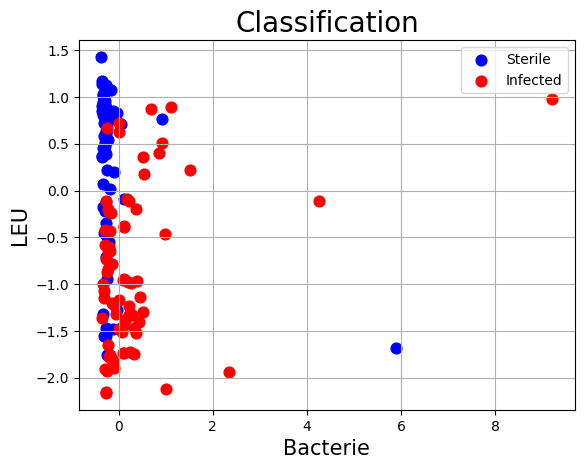

In [85]:
reducedFeaturesForPlot = scaledTrain.iloc[:, list(efs.best_idx_)]
reducedFeaturesForPlot['target'] = Y_train
#plot the first 2 principals components
fig = plt.figure()
ax = fig.add_subplot() 
ax.set_xlabel(scaledTrain.columns[efs.best_idx_[0]], fontsize = 15)
ax.set_ylabel(scaledTrain.columns[efs.best_idx_[1]], fontsize = 15)
ax.set_title('Classification', fontsize = 20)

cond = reducedFeaturesForPlot['target'] == 0

subset_a = reducedFeaturesForPlot[cond]
subset_b = reducedFeaturesForPlot[~cond]
plt.scatter(subset_a.iloc[:,0], subset_a.iloc[:,1], s=60, c='b', label='Sterile')
plt.scatter(subset_b.iloc[:,0], subset_b.iloc[:,1], s=60, c='r', label='Infected') 
ax.legend()
ax.grid()

In [86]:
#https://github.com/datarevenue-berlin/py-MUVR
from py_muvr import FeatureSelector
from concurrent.futures import ProcessPoolExecutor

fs = FeatureSelector(
    n_outer=6,
    n_inner=5,
    n_repetitions=8,
    metric="MISS",
    estimator=LinearSVC(max_iter=10000),
    features_dropout_rate=0.05,
    random_state=1
)
fs.fit(scaledTrain.values, Y_train.values, executor=ProcessPoolExecutor())

feature_names = features.columns
selected_features = fs.get_selected_features()

2023-05-26 14:01:18 py_muvr.feature_selector   INFO    Groups parameter is not specified: independent samples assumed
2023-05-26 14:01:18 py_muvr.feature_selector   INFO    Running 8 repetitions and 6 outer loops using executor ProcessPoolExecutor.
2023-05-26 14:01:18 py_muvr.feature_selector   INFO    Scheduling tasks...


  0% (0 of 48) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (1 of 48) |                         | Elapsed Time: 0:00:00 ETA:  00:00:00
 39% (19 of 48) |#########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (37 of 48) |##################      | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


2023-05-26 14:01:18 py_muvr.feature_selector   INFO    Retrieving results...


  0% (0 of 48) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  2% (1 of 48) |                         | Elapsed Time: 0:00:00 ETA:   0:00:19
  4% (2 of 48) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:18
  6% (3 of 48) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:13
  8% (4 of 48) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:13
 10% (5 of 48) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:12
 12% (6 of 48) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:11
 14% (7 of 48) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:11
 16% (8 of 48) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:11
 18% (9 of 48) |####                     | Elapsed Time: 0:00:02 ETA:   0:00:10
 20% (10 of 48) |#####                   | Elapsed Time: 0:00:02 ETA:   0:00:10
 22% (11 of 48) |#####                   | Elapsed Time: 0:00:02 ETA:   0:00:09
 25% (12 of 48) |######                 

2023-05-26 14:01:30 py_muvr.feature_selector   INFO    Finished feature selection.


In [87]:
scaledTrain = scaledTrain.iloc[:, selected_features["mid"]]
scaledTest = scaledTest.iloc[:, selected_features["mid"]]
fs.get_selected_features(feature_names)

SelectedFeatures(min=['CylP', 'SG', 'LEU', 'GLU', 'CylH', 'Nepi', 'Bacterie', 'KET', 'PRO', 'NIT'], max=['CylP', 'SG', 'GLU', 'CylH', 'LEU', 'Nepi', 'KET', 'Bacterie', 'PRO', 'Crystaux', 'ERY', 'NIT', 'GB', 'Epi', 'GR', 'PH'], mid=['CylP', 'SG', 'LEU', 'CylH', 'GLU', 'Nepi', 'KET', 'Bacterie', 'PRO', 'NIT', 'Crystaux', 'ERY', 'GB'])

## Model fitting

Precision 95% percentile: (0.5555555555555556, 0.5555555555555556)
Recall 95% percentile: (0.5555555555555556, 0.5555555555555556)
Accuracy 95% percentile: (0.7837837837837838, 0.7837837837837838)


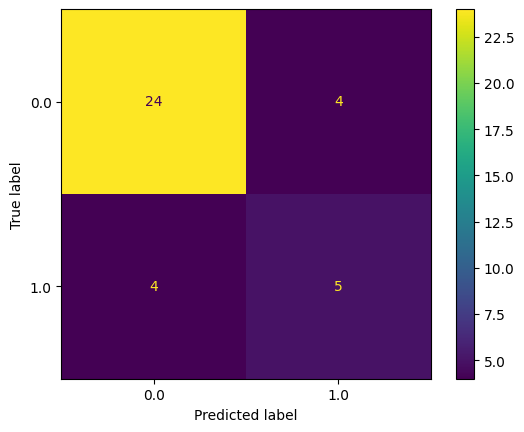

In [88]:
#https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
import statsmodels.stats.api as sms

precision=[]
recall=[]
accuracy=[]

for i in range(2):    
    lr_clf = LinearSVC(max_iter=10000).fit(scaledTrain,Y_train.values.ravel())
    Y_pred = lr_clf.predict(scaledTest)
    precision.append(precision_score(Y_test,Y_pred))
    recall.append(recall_score(Y_test,Y_pred))
    accuracy.append(accuracy_score(Y_test,Y_pred))

print(f"Precision 95% percentile: {sms.DescrStatsW(precision).tconfint_mean()}")
print(f"Recall 95% percentile: {sms.DescrStatsW(recall).tconfint_mean()}")
print(f"Accuracy 95% percentile: {sms.DescrStatsW(accuracy).tconfint_mean()}")
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr_clf.classes_)
disp.plot()


In [89]:
#Equation can be found
sum_prod = sum(lr_clf.coef_[0][i]*scaledTrain.values[0][i] for i in range(len(lr_clf.coef_[0])))
print("The predicted value is", "sterile" if sum_prod + lr_clf.intercept_ >= 0 else "infected")

The predicted value is infected
